In [8]:
import torch
import numpy as np
import scipy.io as sio
import os
import time
from scipy import stats

In [15]:
class EnsemblePursuitPyTorch():
    
    def zscore(self):
        mean_stimuli=self.X.mean(dim=0)
        std_stimuli=self.X.std(dim=0)+0.0000000001
        
        self.X=torch.sub(self.X,mean_stimuli)
        self.X=self.X.div(std_stimuli)
    
    def calculate_cost_delta(self):
        cost_delta=(torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)**2)/(self.sz[0]*torch.matmul(self.current_v,self.current_v))-self.lambd
        #print('cost delta',cost_delta.mean())
        return cost_delta
    
    def fit_one_assembly(self):
        '''
        Function for fitting one cell assembly and computing u and v of the currrent assembly (self.current_u,
        self.current_v).
        One neuron cell assemblies are excluded. 
        '''
        with torch.cuda.device(0) as device:
            #Fake i for initiating while loop. self.i stores the number of neurons in assemblies.
            self.i=1
            #If i is 1, e.g. only one neuron in fit cell assembly, will run fitting the assembly again. 
            #safety it to avoid infinite loops.
            safety_it=0
            n_of_neurons=self.neuron_init_dict['parameters']['n_of_neurons']
            #a variable to switch to random initialization after finding first assembly if the method is
            #selecting neurons from a time point
            self.first_assembly=True
            while self.i==1:
                if self.first_assembly==True:
                    top_neurons=self.select_top_neurons()
                    self.first_assembly=False
                elif self.first_assembly==False and self.neuron_init_dict['method']=='from_time_point':
                    self.self.neuron_init_dict['method']='top_k_corr'
                    top_neurons=self.select_top_neurons()
                elif self.first_assembly==False:
                    top_neurons=self.select_top_neurons()
                #Array of keeping track of neurons in the cell assembly
                self.selected_neurons=torch.zeros([self.sz[1]]).cuda()
                for j in range(0,len(top_neurons)):
                    self.selected_neurons[top_neurons[j]]=1
                #Seed current_v
                self.current_v=self.X[:,top_neurons].mean(1).flatten()
                #print('shp',self.current_v)
                #Fake cost to initiate while loop
                max_delta_cost=1000
                #reset i
                self.i=1
                while max_delta_cost>0:
                    cost_delta=self.calculate_cost_delta()
                    #invert the 0's and 1's in the array which stores which neurons have already 
                    #been selected into the assembly to use it as a mask
                    mask=self.selected_neurons.clone()
                    mask[self.selected_neurons==0]=1
                    mask[self.selected_neurons!=0]=0
                    masked_cost_delta=mask*cost_delta
                    values,sorted_neurons=masked_cost_delta.sort()
                    max_delta_neuron=sorted_neurons[-1]
                    max_delta_cost=values[-1]
                    if max_delta_cost>0:
                        self.selected_neurons[max_delta_neuron.item()]=1
                        self.current_v= self.X[:, self.selected_neurons.tolist()].mean(dim=1)
                    self.i+=1
                safety_it+=1
                #Increase number of neurons to sample from if while loop hasn't been finding any assemblies.
                if safety_it>100:
                    self.neuron_init_dict['parameters']['n_of_neurons']=500
                if safety_it>600:
                    self.neuron_init_dict['parameters']['n_of_neurons']=1000
                if safety_it>1600:
                    raise ValueError('Assembly capacity too big, can\'t fit model')
            #Add final seed neuron to seed_neurons.        
            self.seed_neurons=self.seed_neurons+top_neurons          
            #Calculate u based on final v fit for a cell assembly. 
            self.current_u=torch.clamp(torch.matmul(self.current_v,self.X),min=0,max=None)/torch.matmul(self.current_v,self.current_v)
            self.U=torch.cat((self.U,self.current_u.view(self.X.size(1),1)),1)
            self.V=torch.cat((self.V,self.current_v.view(1,self.X.size(0))),0)
            
    def select_top_neurons(self):
        if self.neuron_init_dict['method']=='top_k_corr':
            n_of_neurons=self.neuron_init_dict['parameters']['n_of_neurons']
            top_neurons,_=self.corr_top_k(n_neurons=n_of_neurons)
            top_neurons=self.select_top_k_corr_neuron(top_neurons,_,n_of_neurons)
        if self.neuron_init_dict['method']=='random':
            top_neurons=[np.random.randint(0,self.sz[1],1)[0]]
        if self.neuron_init_dict['method']=='from_time_point':
            top_neurons=self.select_from_time_point()
        return top_neurons
    
    def select_from_time_point(self):
        threshold=self.neuron_init_dict['parameters']['T']
        threshold_array=(self.original_X>=threshold).sum(dim=1)
        #print('thr_array',threshold_array)
        values,sorted_timepoints=threshold_array.sort()
        timepoint=sorted_timepoints[-1]
        #print('t',timepoint)
        neurons=(self.original_X[timepoint,:]>=threshold).nonzero()
        #print('neurons',neurons)
        return neurons.tolist()
    
    def corrcoef(self,x):
        '''
        Torch implementation of the full correlation matrix.
        '''
        # calculate covariance matrix of columns
        mean_x = torch.mean(x,0)
        xm = torch.sub(x,mean_x)
        c = x.mm(x.t())
        c = c / (x.size(1) - 1)

        # normalize covariance matrix
        d = torch.diag(c)
        stddev = torch.pow(d, 0.5)
        c = c.div(stddev.expand_as(c))
        c = c.div(stddev.expand_as(c).t())

        # clamp between -1 and 1
        c = torch.clamp(c, -1.0, 1.0)

        return c
    
    def corr_top_k(self,n_neurons=100):
        '''
        Finds n_neurons neurons that are on average most correlated to their 
        5 closest neighbors.
        '''
        #Compute full correlation matrix (works with one neuron per column,
        #so have to transpose.)
        corr=self.corrcoef(self.X.t())
        #Sorts each row of correlation matrix
        vals,ix=corr.sort(dim=1)
        #Discards the last entry corresponding to the diagonal 1 and then
        #selects 5 of the largest entries from sorted array.
        top_vals=vals[:,:-1][:,self.sz[1]-6:]
        #Averages the 5 top correlations.
        av=torch.mean(top_vals,dim=1)
        #Sorts the averages
        vals,top_neurons=torch.sort(av)
        #Selects top neurons
        top_neuron=top_neurons[self.sz[1]-(n_neurons+1):]
        top_val=vals[self.sz[1]-(n_neurons+1):]
        return top_neuron,top_val
          
    
    def select_top_k_corr_neuron(self,top_neuron,top_val,n_neurons=100):
        '''
        Randomly samples from k top correlated urons.
        '''
        #Randomly samples a neuron from the n_of_neurons top correlated.
        idx=torch.randint(0,n_neurons,size=(1,))
        print('top n', top_neuron[idx[0]].item(), top_val[idx[0]].item())
        return [top_neuron[idx[0]].item()]
    
    
    def fit_transform(self,X,lambd,n_ensembles,neuron_init_dict):
        torch.manual_seed(7)
        with torch.cuda.device(0) as device:
            self.neuron_init_dict=neuron_init_dict
            self.lambd=lambd
            #Creates cuda tensor from data
            self.X=torch.cuda.FloatTensor(X)
            #z-score data.
            self.zscore()
            #Keep original data for one type of initialization
            if self.neuron_init_dict['method']=='from_time_point':
                self.original_X=self.X.clone()
            #Store dimensionality of X for later use.
            self.sz=self.X.size()
            print('sz',self.sz)
            #Initializes U and V with zeros, later these will be discarded.
            self.U=torch.zeros((self.X.size(1),1)).cuda()
            self.V=torch.zeros([1,self.X.size(0)]).cuda()
            #List for storing the number of neurons in each fit assembly.
            self.nr_of_neurons=[]
            #List for storing the seed neurons for each assembly.
            self.seed_neurons=[]
            cost_lst=[]
            for iteration in range(0,n_ensembles):
                self.fit_one_assembly()
                self.nr_of_neurons.append(self.i)
                U_V=torch.mm(self.current_u.view(self.sz[1],1),self.current_v.view(1,self.sz[0]))
                U_V[U_V != U_V] = 0
                res=(self.X-U_V.t())
                self.X=res
                if iteration==441:
                    print('res',res)
                    print((res!=res).nonzero())
                print('ensemble nr', iteration)
                #print('u',self.current_u)
                #print('v',self.current_v)
                #print('length v', torch.matmul(self.current_v,self.current_v))
                #print('norm',torch.norm(self.X))
                self.cost=torch.mean(torch.mul(res,res))
                print('cost',self.cost)
                cost_lst.append(self.cost.item())
            #After fitting arrays discard the zero initialization rows and columns from U and V.
            self.U=self.U[:,1:]
            self.V=self.V[1:,:]
            print(self.X.size())
            print(self.U.size())
            print(self.V.size())
            return torch.matmul(self.U,self.V).t().cpu(), self.nr_of_neurons, self.U.cpu(), self.V.cpu(), cost_lst, self.seed_neurons

In [4]:
X=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['resp'][0][0]
X[X<0]=0
print(X.shape)
#print(X[0,2])
#X=stats.zscore(X+0.0000001,axis=0)
#print(X[2940,638])

import matplotlib.pyplot as plt
%matplotlib inline

#plt.hist(X.flatten(),range=(-1.2,1.2))

(5880, 10103)


In [18]:
np.random.seed(7)
ep=EnsemblePursuitPyTorch()
s=time.time()
neuron_init_dict={'method':'top_k_corr','parameters':{'T':10,'n_of_neurons':100}}
U_V,nr_of_neurons,U,V, cost_lst,seed_neurons=ep.fit_transform(X,0.005,100,neuron_init_dict)
e=time.time()
print(e-s)
print(nr_of_neurons)
print(cost_lst)

sz torch.Size([5880, 10103])
top n 1608 0.5516875386238098
ensemble nr 0
cost tensor(0.9978, device='cuda:0')
top n 7766 0.6150893568992615
ensemble nr 1
cost tensor(0.9978, device='cuda:0')
top n 4978 0.5524547696113586
ensemble nr 2
cost tensor(0.9965, device='cuda:0')
top n 1408 0.6021430492401123
ensemble nr 3
cost tensor(0.9964, device='cuda:0')
top n 2601 0.595938503742218
ensemble nr 4
cost tensor(0.9963, device='cuda:0')
top n 8217 0.5664743185043335
ensemble nr 5
cost tensor(0.9963, device='cuda:0')
top n 1747 0.6025826334953308
ensemble nr 6
cost tensor(0.9963, device='cuda:0')
top n 4115 0.5907314419746399
ensemble nr 7
cost tensor(0.9963, device='cuda:0')
top n 2422 0.6028700470924377
ensemble nr 8
cost tensor(0.9963, device='cuda:0')
top n 2316 0.5734763145446777
ensemble nr 9
cost tensor(0.9962, device='cuda:0')
top n 1506 0.5711199641227722
ensemble nr 10
cost tensor(0.9961, device='cuda:0')
top n 9367 0.5577781200408936
ensemble nr 11
cost tensor(0.9960, device='cuda:0'

KeyboardInterrupt: 

In [112]:
def test_train_split(data,stim):
    unique, counts = np.unique(stim.flatten(), return_counts=True)
    count_dict=dict(zip(unique, counts))

    keys_with_enough_data=[]
    for key in count_dict.keys():
        if count_dict[key]==2:
            keys_with_enough_data.append(key)

    filtered_stims=np.isin(stim.flatten(),keys_with_enough_data)

    #Arrange data so that responses with the same stimulus are adjacent
    z=stim.flatten()[np.where(filtered_stims)[0]]
    sortd=np.argsort(z)
    istim=np.sort(z)
    X=data[filtered_stims,:]
    out=X[sortd,:].copy()

    x_train=out[::2,:]
    y_train=istim[::2]
    x_test=out[1::2,:]
    y_test=istim[1::2]
    
    return x_train, x_test, y_train, y_test

def evaluate_model(x_train,x_test):
    corr_mat=np.zeros((x_train.shape[0],x_train.shape[0]))
    for j in range(0,x_train.shape[0]):
        for i in range(0,x_test.shape[0]):
            corr_mat[j,i]=np.corrcoef(x_train[j,:],x_test[i,:])[0,1]
    print(np.mean(np.argmax(corr_mat, axis=0) == np.arange(0,x_train.shape[0],1,int)))
    
stim=sio.loadmat('/home/maria/Documents/EnsemblePursuit/data/natimg2800_M170717_MP034_2017-09-11.mat')['stim']['istim'][0][0]
x_train, x_test, y_train, y_test=test_train_split(np.array(V.t()),stim)
evaluate_model(x_train,x_test)

KeyboardInterrupt: 

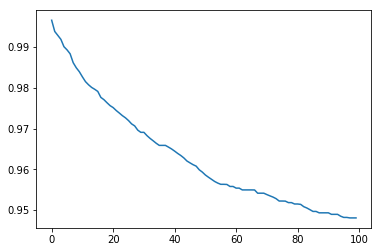

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(range(0,100),cost_lst)